## N.B. Before you run this notebook!!!

If you are running this notebook on Google Colab, please make sure to enable hardware acceleration using either a GPU or a TPU. If it is run with CPU-only enabled, generating the word embeddings will take an incredibly long time! Hardware acceleration can be enabled by navigating to `Runtime` -> `Change Runtime`. This will present you with a popup, where you can select an appropriate `Hardware Accelerator`.

<a href="https://colab.research.google.com/github/arangodb/interactive_tutorials/blob/master/notebooks/WordEmbeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Word Embeddings



In this notebook, we will use word embeddings to perform searches based on movie descriptions in ArangoDB. 

We'll start by breaking down how to convert a string into a set of word embeddings produced by a state-of-the-art Transformer model. Then we'll use a higher-level API to create embeddings and compare them so that you can see their expressive power!
Finally, we'll create embeddings for movie descriptions in our IMDb graph and perform similarity searches and query-based searches.

## Introduction to Word Embeddings

Transforming text so that it can be used efficiently and processed correctly by computers has long been an open problem in Natural Language Processing (NLP). Word embeddings are a development that has been considered a breakthrough in this area. If you've ever used voice assistants such as Amazon Alexa or Siri, a translation service such as Google Translate, or a search engine - you've come into contact with applications of word embeddings! 


Now you might be wondering: What is a word embedding?

Word embeddings are a numerical representation of text, consisting of ordered sequences of numbers called vectors. The intuition behind these embeddings is that words that appear in similar contexts and share similar meanings should have similar embeddings. In practice, these representations are vectors that are calculated based on the setting that they are in. These vectors are unique per word, so if we were to retrieve the embedding for `king`, it would have a different embedding than `man`. Since these embeddings contain a representation of meaning, we can also use them to do approximate math. For example, if we do `king - man + woman`, we will end up with a vector that is close to the `queen` word embedding. It's important to note that the context matters. This effect is most pronounced if your text contains homonyms. Homonyms are words that have the same spelling but different meanings. For example, `address` has a different meaning in the following sentences:
 
 ```"He was about to address the congregation."```

 ```"I would like to update my current address."```

In this case, the word embedding you would compute for the word `address` will differ per sentence (provided you are using a recent embedding model).



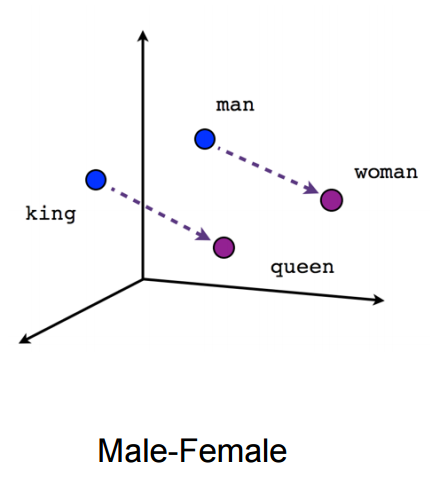

[From [Google's Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/embeddings/translating-to-a-lower-dimensional-space)]

These embeddings are created by training a neural network model to predict the context around a target word (the target word is the one we're trying to make an embedding for). The first word embedding models used a sliding window around the target word as the relevant context. An example of a sliding window around `"fox"` can be seen below:

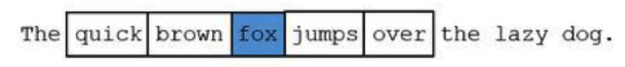

[Example of a sliding window. From Wittum, Gabriel & Hoffer, Michael & Lemke, Babett & Jabs, Robert & Naegel, Arne. (2020). Automated methods for the comparison of natural languages. Computing and Visualization in Science. 23. 10.1007/s00791-020-00325-2.]

Recently, research has yielded a new mechanism for taking context into account: Attention. Attention is a mechanism that allows a model to focus on the relevant parts of an input text as needed. The idea of attention stems from the notion that all the words used in a sentence are interconnected, and the model should use those hidden connections at the appropriate time to link words together. These connections can span entire sentences (and, in some cases, even paragraphs), so they aren't limited to a single sliding window, dramatically increasing the expressive power of these representations. 
 

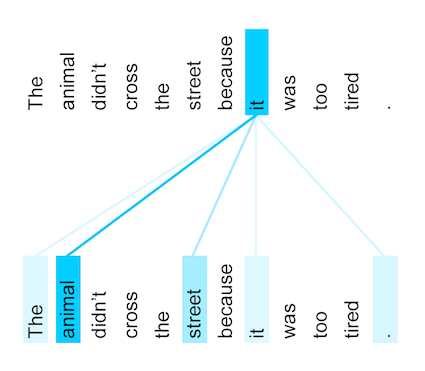

[An example of attention in a sentence. From the [Google AI Blog](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html)]

Here we can see an example of attention in action. The attention mechanism correctly places a higher emphasis on "animal" when calculating the attention for the word "it" in the sentence.

The first model that introduced this (and afterward spawned a whole host of improvements) is known as a Transformer. It has managed to achieve state-of-the-art results for tasks related to word embeddings such as [Language Modeling](https://en.wikipedia.org/wiki/Language_model). 


The building block of a Transformer model is known as multi-headed attention, which is a set of multiple attention layers applied in parallel to the same input. This allows the model to pay attention to different aspects of the input text simultaneously. Multiple multi-headed attention blocks are stacked on top of one another until we reach a final representation for each word in the input text. This may seem difficult to understand, but don't worry! We've included an interactive visualization of multi-headed attention in the tutorial below.

<img src="https://www.researchgate.net/publication/334288604/figure/download/fig1/AS:778232232148992@1562556431066/The-Transformer-encoder-structure.ppm" width=250 alt="Transformer model">

[The internals of a Transformer embedding model. From Castellucci, Giuseppe & Bellomaria, Valentina & Favalli, Andrea & Romagnoli, Raniero. (2019). Multi-lingual Intent Detection and Slot Filling in a Joint BERT-based Model.]

The representations produced by these models will be the core focus of this notebook. If you would like a more in-depth visual explanation of word embeddings and Transformer models you can read these excellent posts by Jay Lammar: [Illustrated Word2Vec](https://jalammar.github.io/illustrated-word2vec/) and [Illustrated Transformers](https://jalammar.github.io/illustrated-transformer/). 


Once a word embedding model such as a Transformer has been trained on a large dataset, typically consisting of millions of sentences, the embeddings are ready for use in downstream tasks. 

This notion of "train once - use everywhere" is a concept called Transfer Learning. By pre-training embeddings on a large corpus, the resultant embeddings are well-generalized and are effective in various settings. In this notebook, we'll be using pre-trained embeddings when calculating our movie similarities.

However, it is important to note that there is no such thing as one size fits all, as different domains use words in different contexts with different meanings. To address this, you can apply what is known as fine-tuning - which is a process where you take the pre-trained model and train it further on a corpus for your specific application. We won't be going into further detail here, but if you would like to learn more, here are some resources to get you started: 

* https://medium.com/skilai/language-model-fine-tuning-for-pre-trained-transformers-b7262774a7ee
* https://huggingface.co/transformers/training.html

# Setup

In [ ]:
%%capture
!git clone -b oasis_connector --single-branch https://github.com/arangodb/interactive_tutorials.git
!rsync -av interactive_tutorials/ ./ --exclude=.git
!chmod -R 755 ./tools
!git clone -b imdb_complete --single-branch https://github.com/arangodb/interactive_tutorials.git imdb_complete
!rsync -av imdb_complete/data/imdb_dump/ ./imdb_dump/
!pip3 install torch
!pip3 install transformers
!pip3 install sentence-transformers
!pip3 install bertviz
!pip3 install pyarango
!pip3 install "python-arango>=5.0"

In [ ]:
import itertools
import json
import requests
import sys
import oasis
import time
import textwrap

from pyArango.connection import *
from arango import ArangoClient
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
import torch.nn.functional as F
import torch
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from bertviz import head_view

# Creating Word Embeddings

Here we're creating our Transformer model:

In [ ]:
%%capture
model_name = "distilbert-base-uncased"
model = AutoModel.from_pretrained(model_name, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)

The model consists of two components: the actual model, and a tokenizer. The tokenizer splits the input string into a series of tokens.

In [ ]:
tokenized = tokenizer("This is an input sentence!", return_tensors="pt")
tokenized

We can also decode the tokens:

In [ ]:
tokenizer.decode(tokenized["input_ids"].tolist()[0])

When we do so, we can see that some special tokens have been inserted. `[CLS]` is the Class token, which is used for downstream classification tasks, and, in our case, as a token that when embedded, represents the embedding of our entire input string.

Now that we have a tokenized representation, we can then calculate the actual word embeddings:

In [ ]:
model_output = model(**tokenized)
print(model_output.last_hidden_state)

## Visualizing Multi-headed Attention

We can also visualize the attention heads across all of the stacked multi-headed attention blocks below. Running this cell will produce an interactive graphic!


In [ ]:
sentence = "Jack was tired so he went to sleep"
tokenized_sent = tokenizer(sentence, return_tensors="pt")
preds = model(**tokenized_sent)

attention = preds[-1]
tokens = tokenizer.convert_ids_to_tokens(tokenized_sent["input_ids"][0].tolist())
head_view(attention, tokens)

The visualization above is interactive. The first thing that you can filter on is which layer of multi-headed attention you are viewing. The transformer model we're using has 6 layers, so you can switch between the various layers using the dropdown. Each of the colors corresponds with one of the 12 individual attention heads in that layer. These can be toggled on and off. By hovering over individual tokens, you can view the attention to and from that token! The opacity of each connection signifies its strength.

We've included an example of how you can interact with this below. Here you can see that one attention head (pink) focuses on "jack" when we hover over "jack", but another (green) focuses on "he"! Other attention heads are less opaque (for example, the purple attention head on "he" and "was"), but as we mentioned before, these are less strong. 

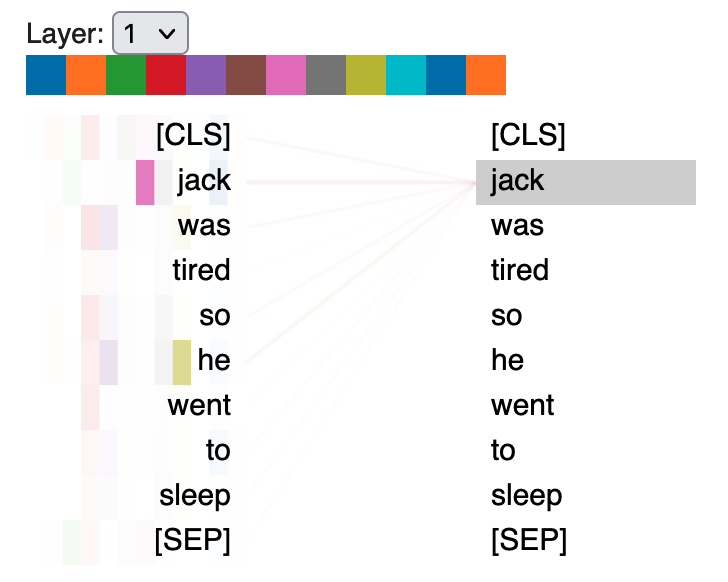

# Word Embedding Similarities

Now that we've seen how some of the parts of this model fit together, we can make use of a higher level abstraction. Sentence transformers give us an easier API for computing sentence level embeddings. These sentence level embeddings are derived from the `[CLS]` token mentioned above.

In [ ]:
%%capture
model = SentenceTransformer("paraphrase-TinyBERT-L6-v2")

def embed_and_compare(inputs):
  input_embeddings = torch.from_numpy(model.encode(inputs))

  n = input_embeddings.shape[0]

  combos = list(itertools.product(list(range(n)), list(range(n))))

  for a, b in combos:
    if a == b or a > b:
      continue
    print(f"1st input: {inputs[a]}")
    print(f"2nd input: {inputs[b]}")

    cosine_sim = F.cosine_similarity(input_embeddings[a], input_embeddings[b], dim=0).numpy()
    print(f"Cosine similarity: {cosine_sim:.3f}")
    print("\n")

We can use this package to calculate the similarity of terms such as synonyms and antonyms. As mentioned previously, embeddings are vectors, so we can use a metric called cosine similarity, which works on non-zero vectors to measure the similarity between them. This metric measures the cosine of the angle between two vectors and can be calculated for embeddings $\vec{a}$ and $\vec{b}$, both of length $n$ (read: the dimensionality of the embedding) as follows:
$$
\text{cosine_similarity}(\vec{a}, \vec{b}) = \cos(\theta) =  \frac{
  \sum\limits_{i=1}^{n}{a_i b_i}
  }{
      \sqrt{\sum\limits_{j=1}^{n}{a_j^2}}
      \sqrt{\sum\limits_{k=1}^{n}{b_k^2}}
  }
$$

Here $\theta$ denotes the angle between the vectors. 
Cosine similarity can take on values between -1 and 1. A value of 1 means that the vectors are identical, while -1 means that they are pointing in opposite directions (so they are not similar). 


Using this metric, let's calculate the similarity between some synonyms and antonyms!

In [ ]:
# Handle synonyms and antonyms
terms = [
    "happy",
    "cheerful", 
    "sad"
]
embed_and_compare(terms)

As you can see, the synonyms "happy" and "cheerful" have a very high cosine similarity, while the antonym "sad" is far less similar.

We can also use these embeddings to calculate sentence similarities! Let's embed a few similar sounding sentences, and throw in a couple of unrelated sentences too, and see how similar they are:

In [ ]:
sentences = [
    "This is an input sentence",
    "Totally unrelated thing.",
    "This is an input query.",
    "This is another sentence!",
]
embed_and_compare(sentences)

As you can see, the unrelated sentence "Totally unrelated thing" with no words in common with the other three had a very low similarity in all 3 of its comparisons. The model also demonstrates that it's able to handle words in similar contexts ("sentence" v. "query") to score the closest sentences the highest ("This is an input sentence" and "This is an input query")!

# ArangoDB Setup

Now that we have a better idea of Transformer word embedding models can aid us in text search and comparison, let's start to apply it to a graph. To do so we'll first need to configure our database and load the data.

Create the temporary database:

In [ ]:
# Retrieve tmp credentials from ArangoDB Tutorial Service
login = oasis.getTempCredentials(tutorialName="WordEmbeddings", credentialProvider="https://tutorials.arangodb.cloud:8529/_db/_system/tutorialDB/tutorialDB")

# Connect to the temp database
# Please note that we use the python-arango driver as it has better support for ArangoSearch 
database = oasis.connect_python_arango(login)

In [ ]:
print("https://"+login["hostname"]+":"+str(login["port"]))
print("Username: " + login["username"])
print("Password: " + login["password"])
print("Database: " + login["dbName"])

Feel free to use the above URL to checkout the ArangoDB WebUI!

# Import IMDB Example Dataset

![imdb](https://github.com/arangodb/interactive_tutorials/blob/master/notebooks/img/IMDB_graph.png?raw=1)

Next we will import the [IMBD Example Dataset](https://github.com/arangodb/example-datasets/tree/master/Graphs/IMDB) which contains information about various movies, actors, directors, ... as a graph. 
**N.B.** the included arangorestore will only work on Linux or Windows systems, if you want to run this notebook on a different OS please consider using the appropriate arangorestore from the [Download area](https://www.arangodb.com/download-major/).

# Linux

In [ ]:
! ./tools/arangorestore -c none --server.endpoint http+ssl://{login["hostname"]}:{login["port"]} --server.username {login["username"]} --server.database {login["dbName"]} --server.password {login["password"]} --default-replication-factor 3  --input-directory "imdb_dump"

# Movie Description Embeddings

Start by retrieving all movies that we want to produce description embeddings for.

In [ ]:
cursor = database.aql.execute(
"""
FOR d IN imdb_vertices 
   FILTER d.type == "Movie"
   FILTER d.description != "No overview found."
   RETURN {
     _id: d._id,
     description: d.description
    }
"""
)
movie_descriptions = list(cursor)

# let's take this list of movie descriptions and put it in a dataframe for ease of use
movies_df = pd.DataFrame(movie_descriptions)
movies_df = movies_df.dropna()

Next, we can produce the embeddings.

In [ ]:
# Now iterate over the descriptions and produce the sentence embeddings
batch_size = 32

all_embs = []

for i in tqdm(range(0, len(movies_df), batch_size)):
  descr_batch = movies_df.iloc[i:i+batch_size].description.tolist()
  embs = model.encode(descr_batch)
  all_embs.append(embs)

all_embs = np.concatenate(all_embs)
movies_df.loc[:, "word_emb"] = np.vsplit(all_embs, len(all_embs))
movies_df["word_emb"] = movies_df["word_emb"].apply(lambda x: x.squeeze().tolist())

Now let's upload these embeddings to our ArangoDB database in batches.

In [ ]:
BATCH_SIZE = 250
movie_collection = database["imdb_vertices"]

for i in range(0, len(movies_df), batch_size):
  update_batch = movies_df.loc[i:i+batch_size, ["_id", "word_emb"]].to_dict("records")
  movie_collection.update_many(update_batch)

# Similarity Search Using Embeddings

Once the embeddings have been uploaded, we can query the database and use these embeddings to find the most similar movies based on their description's embeddings!

In [ ]:
cursor = database.aql.execute(
"""
  FOR m in imdb_vertices
    FILTER m._id == "imdb_vertices/28685"
    RETURN { "title": m.title, "description": m.description }
""")

# Iterate through the result cursor
for doc in cursor:
  print(doc)

Let's see if we can retrieve movies that are similar to "The Karate Killers".

In [ ]:
cursor = database.aql.execute(
"""
LET descr_emb = (
  FOR m in imdb_vertices
    FILTER m._id == "imdb_vertices/28685"
    FOR j in RANGE(0, 767)
      RETURN TO_NUMBER(NTH(m.word_emb,j))
)

LET descr_mag = (
  SQRT(SUM(
    FOR i IN RANGE(0, 767)
      RETURN POW(TO_NUMBER(NTH(descr_emb, i)), 2)
  ))
)

LET dau = (

    FOR v in imdb_vertices
    FILTER HAS(v, "word_emb")

    LET v_mag = (SQRT(SUM(
      FOR k IN RANGE(0, 767)
        RETURN POW(TO_NUMBER(NTH(v.word_emb, k)), 2)
    )))

    LET numerator = (SUM(
      FOR i in RANGE(0,767)
          RETURN TO_NUMBER(NTH(descr_emb, i)) * TO_NUMBER(NTH(v.word_emb, i))
    ))

    LET cos_sim = (numerator)/(descr_mag * v_mag)

    RETURN {"movie": v._id, "title": v.title, "cos_sim": cos_sim}

    )

FOR du in dau
    SORT du.cos_sim DESC
    LIMIT 50
    RETURN {"movie": du.title, "cos_sim": du.cos_sim} 
""")

# Iterate through the result cursor
for doc in cursor:
  print(doc)

Here we're using the cosine similarity to retrieve the closest matches to Karate Killer based on the embeddings of their movie descriptions. We're calculating this metric based on the equation we previously mentioned above:
$$
 \frac{
  \sum\limits_{i=1}^{n}{a_i b_i}
  }{
      \sqrt{\sum\limits_{j=1}^{n}{a_j^2}}
      \sqrt{\sum\limits_{k=1}^{n}{b_k^2}}
  }
$$



Once we calculate the cosine similarities, we can then SORT the movies and return the top 50 most similar movies!

# Search Using Query Embeddings

We aren't necessarily limited to the embeddings that we have in the graph already. We can also use a query with search terms.


In [ ]:
# Query something specific

search_term = "jedi stars fighting"
search_emb = model.encode(search_term).tolist()

Here we're embedding our search terms into one vector. Below we're then loading this embedding into the same query that we used above:

In [ ]:
emb_str = f"""
LET descr_emb = (
  {search_emb}
)
"""
cursor = database.aql.execute(
emb_str + """
LET descr_size = (
  SQRT(SUM(
    FOR i IN RANGE(0, 767)
      RETURN POW(TO_NUMBER(NTH(descr_emb, i)), 2)
  ))
)

LET dau = (

    FOR v in imdb_vertices
    FILTER HAS(v, "word_emb")

    LET v_size = (SQRT(SUM(
      FOR k IN RANGE(0, 767)
        RETURN POW(TO_NUMBER(NTH(v.word_emb, k)), 2)
    )))

    LET numerator = (SUM(
      FOR i in RANGE(0,767)
          RETURN TO_NUMBER(NTH(descr_emb, i)) * TO_NUMBER(NTH(v.word_emb, i))
    ))

    LET cos_sim = (numerator)/(descr_size * v_size)

    RETURN {"movie": v._id, "title": v.title, "cos_sim": cos_sim}

    )

FOR du in dau
    SORT du.cos_sim DESC
    LIMIT 50
    RETURN {"movie": du.title, "cos_sim": du.cos_sim} 
""")

# Iterate through the result cursor
for doc in cursor:
  print(doc)

We managed to find a bunch of Star Wars movies - hopefully, what you expected to see!

# Next Steps

In this tutorial we've learned how to take unstructured text, and use it to perform similarity searches in ArangoDB. If you would like to continue learning more about ArangoDB, here are some next steps to get you started!

* [Get a 2 week free Trial with the ArangoDB Cloud](https://cloud.arangodb.com/home?utm_source=AQLJoin&utm_medium=Github&utm_campaign=ArangoDB%20University)
* [Download ArangoDB](https://www.arangodb.com/download-major/)
* [ArangoDB Training Center](https://www.arangodb.com/learn/)
* [Getting Started with ArangoDB - Udemy](https://www.udemy.com/course/getting-started-with-arangodb/)